### Diego Elian Rodriguez A00829925

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
# import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
    
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import gc
from IPython.display import Markdown, display
def printmd(string):   
    display(Markdown(string))

In [6]:
np.random.seed(0)

def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [8]:
images = []
dirp = "kaggle/"

for f in os.listdir(dirp):
    if "png" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else: 
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)

df = pd.DataFrame(images, columns = ["fruit", "path"])

from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

fruit_names = sorted(df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
df["label"] = df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

df.head()

{'Apple': 0, 'Banana': 1, 'Carambola': 2, 'Guava': 3, 'Kiwi': 4, 'Mango': 5, 'Orange': 6, 'Peach': 7, 'Pear': 8, 'Persimmon': 9, 'Pitaya': 10, 'Plum': 11, 'Pomegranate': 12, 'Tomatoes': 13, 'muskmelon': 14}


fruit                                               path  label
0        Apple           kaggle/Apple/Apple F\Apple F _0_2509.png      0
1        Apple               kaggle/Apple/Apple D\applee14300.png      0
2         Kiwi  kaggle/Kiwi/Total Number of Kiwi fruit\Kiwi003...      4
3  Pomegranate            kaggle/Pomegranate\Pomegranet002119.png     12
4        Guava      kaggle/Guava/guava total final\Guava03019.png      3

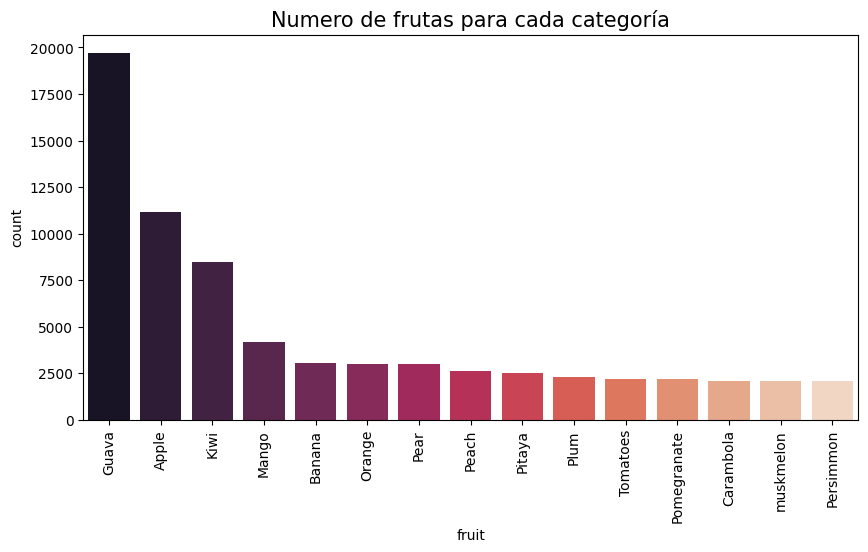

In [10]:
vc = df["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Numero de frutas para cada categoría", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

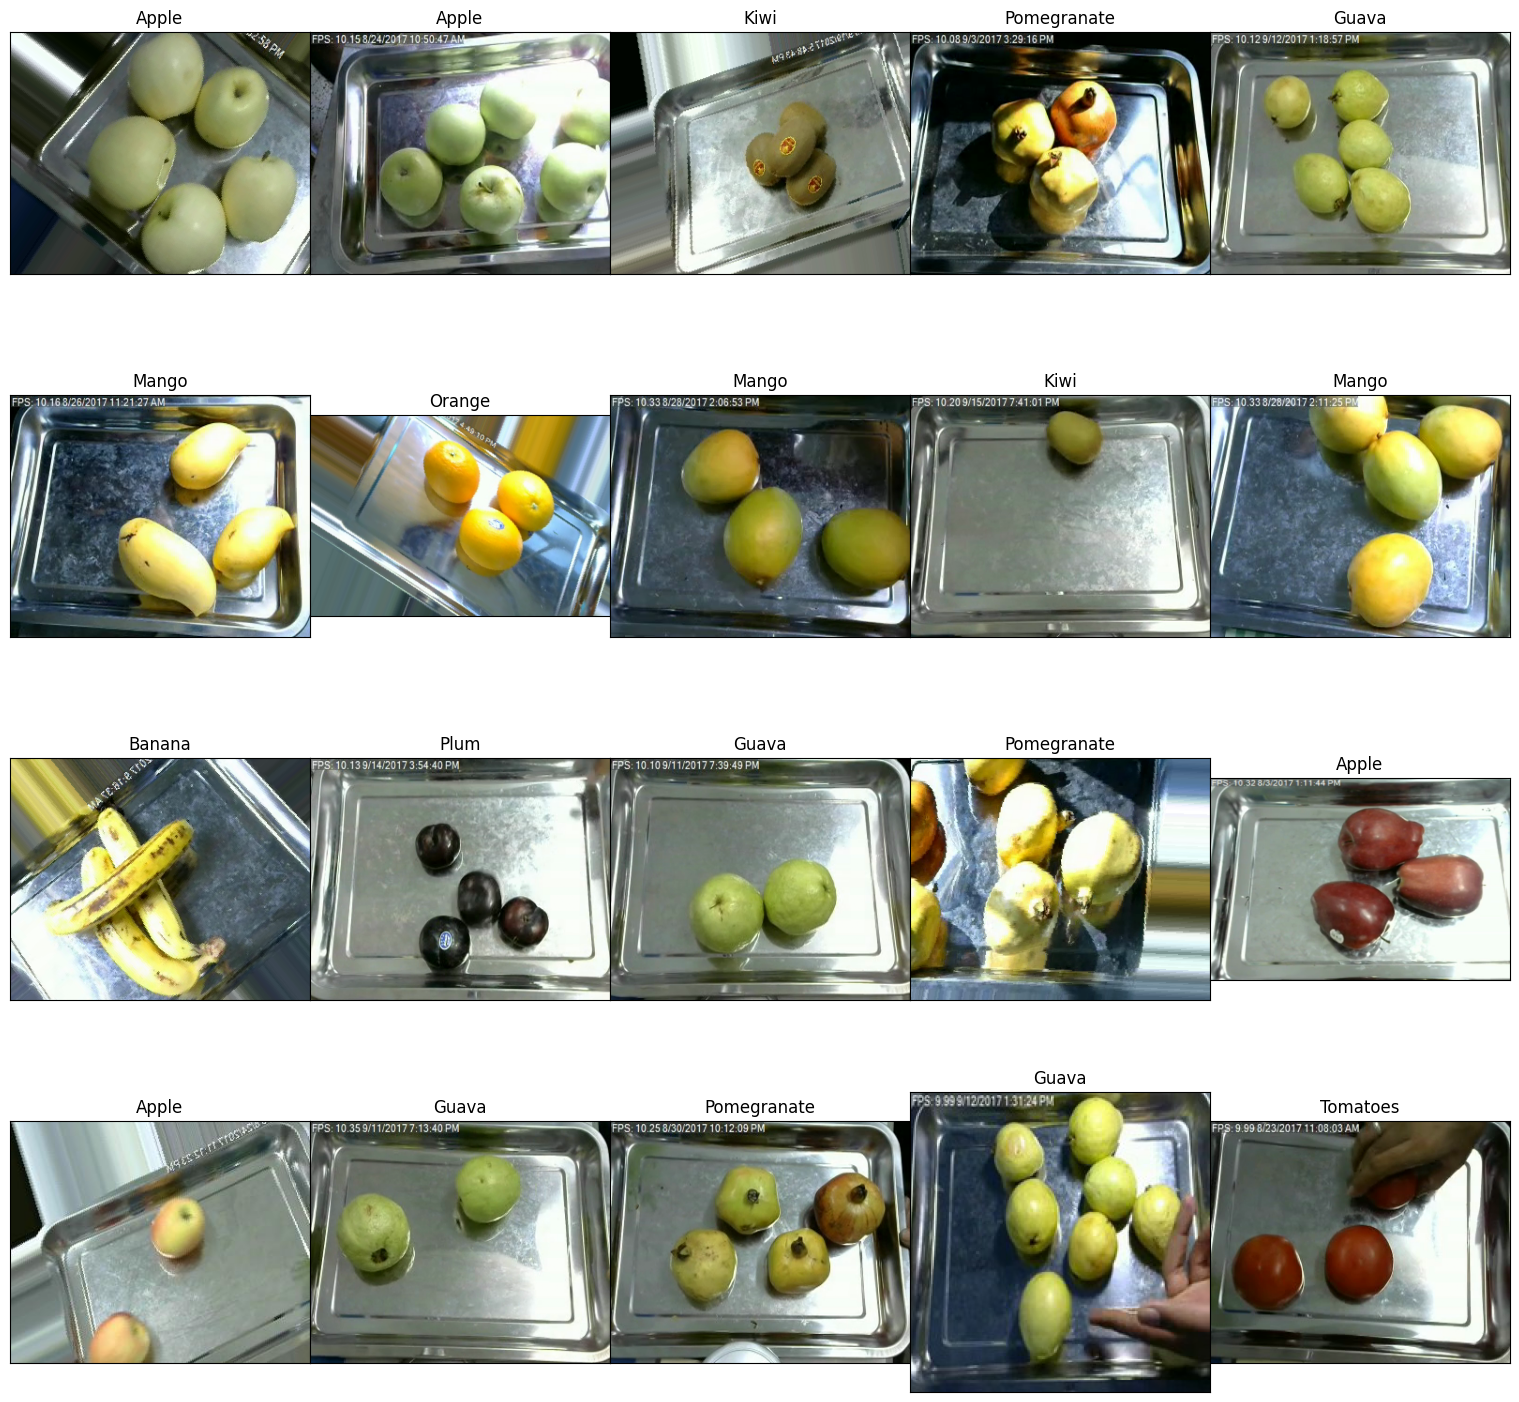

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i]))
    ax.set_title(df.fruit[i], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

## Modelo

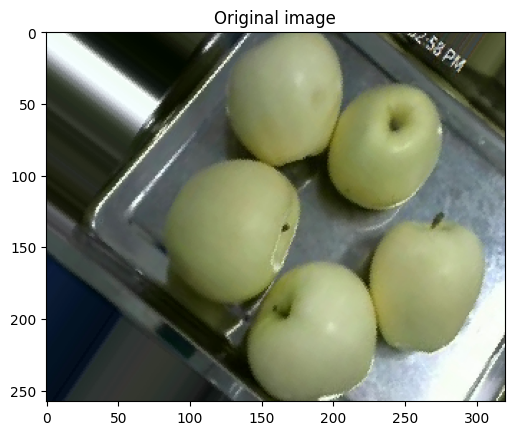

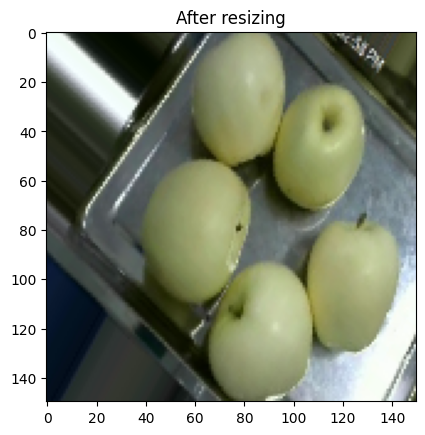

In [12]:
img = plt.imread(df.path[0])
plt.imshow(img)
plt.title("Original image")
plt.show()

plt.imshow(cv2.resize(img, (150,150)))
plt.title("After resizing")
plt.show()

In [13]:
def cut_df(df, number_of_parts, part):
    if part < 1:
        print("Error, the part should be at least 1")
    elif part > number_of_parts:
        print("Error, the part cannot be higher than the number_of_parts")
        
    number_imgs_each_part = int(df.shape[0]/number_of_parts)
    idx1 = (part-1) * number_imgs_each_part
    idx2 = part * number_imgs_each_part
    return df.iloc[idx1:idx2]

def load_img(df):
    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []
    
    for i,path in enumerate(img_paths):
        img =  plt.imread(path)
        img = cv2.resize(img, (150,150))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),np.array(y)

In [51]:
##  modelo

def create_model():
    shape_img = (150,150,3)
    
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(mapper_fruit_names)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model
    

In [41]:
def from_categorical(lst):
    """
    Inverse of to_categorical
    Example: [[0,0,0,1,0], [1,0,0,0,0]] => [3,0]
    """
    
    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(x.index(max(x)))
    return lst2

def display_stats(y_test, pred):
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = from_categorical(y_test)
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred))
    print("\n")
    printmd(f"# Accuracy: {round(accuracy_score(y_test_class, pred),5)}")
    
def plot_training(model):
    history = pd.DataFrame(model.history.history)
    history[["accuracy","val_accuracy"]].plot()
    plt.title("Training results")
    plt.xlabel("# epoch")
    plt.show()

In [42]:
model = create_model()
hists = []
divisor = 5

start_time = time.time()
X_train, y_train = load_img(cut_df(df,divisor,1))
y_train = to_categorical(y_train)
callbacks = [EarlyStopping(monitor='val_loss', patience=30),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [43]:

model.fit(X_train, y_train, batch_size=128, epochs=15, callbacks=callbacks, validation_split = 0.1, verbose = 1)
hists.append(model.history.history)

Epoch 1/15
100/100 [==============================] - 180s 2s/step - loss: 2.4583 - accuracy: 0.3538 - val_loss: 1.2294 - val_accuracy: 0.6123
Epoch 2/15
100/100 [==============================] - 210s 2s/step - loss: 1.0022 - accuracy: 0.6918 - val_loss: 0.4615 - val_accuracy: 0.8498
Epoch 3/15
100/100 [==============================] - 196s 2s/step - loss: 0.6281 - accuracy: 0.8281 - val_loss: 1.1850 - val_accuracy: 0.6768
Epoch 4/15
100/100 [==============================] - 193s 2s/step - loss: 0.5917 - accuracy: 0.8266 - val_loss: 0.2872 - val_accuracy: 0.8979
Epoch 5/15
100/100 [==============================] - 194s 2s/step - loss: 0.3692 - accuracy: 0.9036 - val_loss: 0.4809 - val_accuracy: 0.8724
Epoch 6/15
100/100 [==============================] - 192s 2s/step - loss: 0.5066 - accuracy: 0.8538 - val_loss: 0.2496 - val_accuracy: 0.9093
Epoch 7/15
100/100 [==============================] - 194s 2s/step - loss: 0.4543 - accuracy: 0.9178 - val_loss: 0.4424 - val_accuracy: 0.8526

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [44]:
gc.collect()

81809

In [45]:
time_model = time.time() - start_time
print(f"Time to train the model: {int(time_model)} seconds")

Time to train the model: 3162 seconds


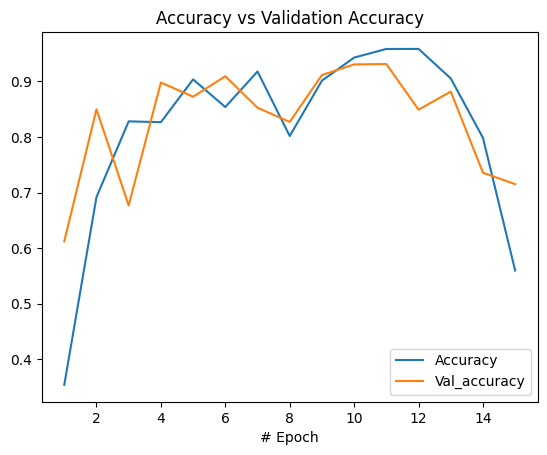

In [48]:
acc = []
val_acc = []
for i in range(len(hists)):
    acc += hists[i]["accuracy"]
    val_acc += hists[i]["val_accuracy"]
hist_df = pd.DataFrame({"# Epoch": [e for e in range(1,len(acc)+1)],"Accuracy": acc, "Val_accuracy": val_acc})
hist_df.plot(x = "# Epoch", y = ["Accuracy","Val_accuracy"])
plt.title("Accuracy vs Validation Accuracy")
plt.show()

In [50]:
import warnings
warnings.filterwarnings("ignore")
def display_stats(y_test, pred_probs):
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = np.argmax(y_test, axis=1)  
    pred_class = np.argmax(pred_probs, axis=1)  # Obtener las clases predichas desde las probabilidades
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred_class))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred_class))
    print("\n")
    print(f"# Accuracy: {round(accuracy_score(y_test_class, pred_class),5)}")

X, y = load_img(cut_df(df, 20, 20))
pred = model.predict(X) 
y_test = to_categorical(y)

display_stats(y_test, pred)

111/111 [==============================] - 11s 99ms/step
### Result of the predictions using 3527 test data ###

Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.67      0.65       573
           1       0.66      0.38      0.48       149
           2       0.67      0.41      0.51       107
           3       0.87      0.95      0.91      1022
           4       0.80      0.88      0.84       411
           5       0.63      0.64      0.63       183
           6       0.55      0.56      0.56       149
           7       0.57      0.60      0.58       148
           8       0.68      0.58      0.63       144
           9       0.69      0.59      0.64       111
          10       0.54      0.45      0.49        97
          11       0.90      0.95      0.93       119
          12       0.64      0.72      0.68       105
          13       0.51      0.42      0.46       117
          14       0.86      0.59      0.70        9

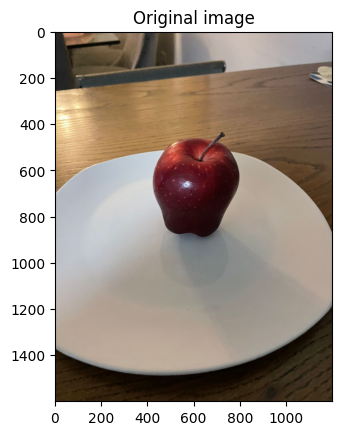

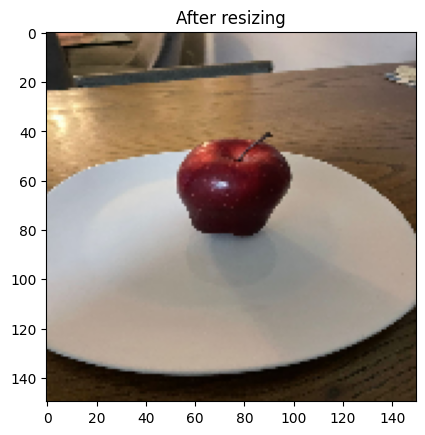

In [71]:
img = plt.imread(fname="Manzana.jpg")
plt.imshow(img)
plt.title("Original image")
plt.show()

plt.imshow(cv2.resize(img, (150,150)))
plt.title("After resizing")
plt.show()

X = []
img = cv2.resize(img, (150,150))  # Asegúrate de que img tiene la forma (150, 150, 3)
X.append(img)
X = np.array(X)  # Convierte la lista en un array numpy
X = X.reshape(-1, 150, 150, 3)  # Asegúrate de que X tenga la forma correcta (batch_size, height, width, channels)


In [95]:
pred = model.predict(X)
y_test = to_categorical(pred)
fruit_names[from_categorical(pred)[0]]

1/1 [==============================] - 0s 31ms/step


'Apple'